## Tune the model to higher firing rate

In [5]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.loader import DataLoader

sys.path.append("..")
from spiking_network.models import SpikingModel
from spiking_network.datasets import W0Dataset, GlorotParams

In [6]:
# Create a dataset of random connectivity matrices to train on
n_neurons = 100
n_datasets = 5
w0_dataset = W0Dataset(n_neurons, n_datasets, GlorotParams(0, 5))

data_loader = DataLoader(w0_dataset, batch_size=1, shuffle=False)

In [8]:
# Create a model to tune
model = SpikingModel(tuneable_parameters=["threshold", "alpha", "beta"])

# Train the model
for batch_idx, batch in enumerate(data_loader):
    model.tune(batch, firing_rate=0.1, n_steps=100)

Tuning... p=0.09646: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


In [9]:
# Create a dataset of random connectivity matrices to test on
n_neurons = 100
n_datasets = 10
w0_dataset = W0Dataset(n_neurons, n_datasets, GlorotParams(0, 5))

data_loader = DataLoader(w0_dataset, batch_size=1, shuffle=False)

# Test the model
results = []
for batch_idx, batch in enumerate(data_loader):
    X = model.simulate(batch, n_steps=10000)
    results.append(X)

100%|██████████| 10000/10000 [00:06<00:00, 1661.28it/s]


In [15]:
# Calculate the firing rate of the model on the test set
fr = torch.mean(torch.stack([torch.sum(X)/(torch.prod(torch.tensor(X.shape))) for X in results]), dim=0)
print(f"Average firing rate for simulations: {fr.item():.5f}")

Average firing rate for simulations: 0.10049


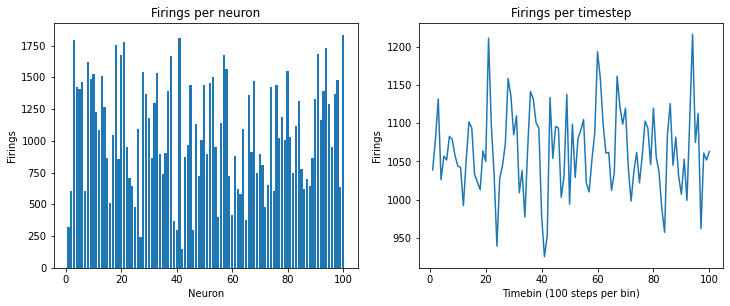

: 

In [17]:
# Plot the results for the first simulation
X = results[0]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
fig.set_figheight(4.5)
fig.set_figwidth(12)

axes[0].set_title("Firings per neuron")
axes[0].set_ylabel("Firings")
axes[0].set_xlabel("Neuron")
axes[0].bar(range(1, n_neurons + 1), torch.sum(X, axis=1), lw=0)

axes[1].set_title("Firings per timestep")
axes[1].set_ylabel("Firings")
axes[1].set_xlabel(f"Timebin ({10000 // 100} steps per bin)")
axes[1].plot(range(1, 101), torch.sum(X, axis=0).reshape(100, -1).sum(axis=0))